# Should I Apply?
## Classifying Job Listings as Authentic or Fraudulent

### Sophia Stewart
#### January 24, 2022
---

## Project Overview
The goal of this project is to identify elements of fraudulent job postings so that I can predict whether or not a job posting is real. Fraudulent job postings are dangerous and becoming more sophisticated as time goes on. By creating a method of accurately classifying job postings as real or fake, some of the anxiety and danger of the job-searching process can be eliminated. Using data I acquired from Kaggle, I created three models to predict whether a job posting is authentic or fraudulent. My best model is a Random Forest model with an accuracy of 95.32% on unseen data.

---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import wrangle as w
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# to ignore any pink warnings
import warnings
warnings.filterwarnings("ignore")

## Data Wrangling

To prepare this data, I:
- Dropped rows with null values if they comprised less than 10% of the data in a column
- Binned values into fewer categories
- Created dummy variables from those bins
- Dropped columns that were not helpful or that had more than 50% of their data missing

In [2]:
# get data
jobs = w.wrangle_jobs()
jobs.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,continent,employment_type_Employee,employment_type_Non-employee,...,required_experience_Med,required_education_College,required_education_None,required_education_Vocational,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA
0,0,1,0,Unspecified,Low,None,0,NA,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,0,Employee,Low,None,0,OC,1,0,...,0,0,1,0,0,0,0,0,1,0
2,0,1,0,Unspecified,Low,None,0,NA,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,1,0,Employee,Med,College,0,NA,1,0,...,1,1,0,0,0,0,0,1,0,0
4,0,1,1,Employee,Med,College,0,NA,1,0,...,1,1,0,0,0,0,0,1,0,0


---
## Data Exploration

### Univariate Analysis

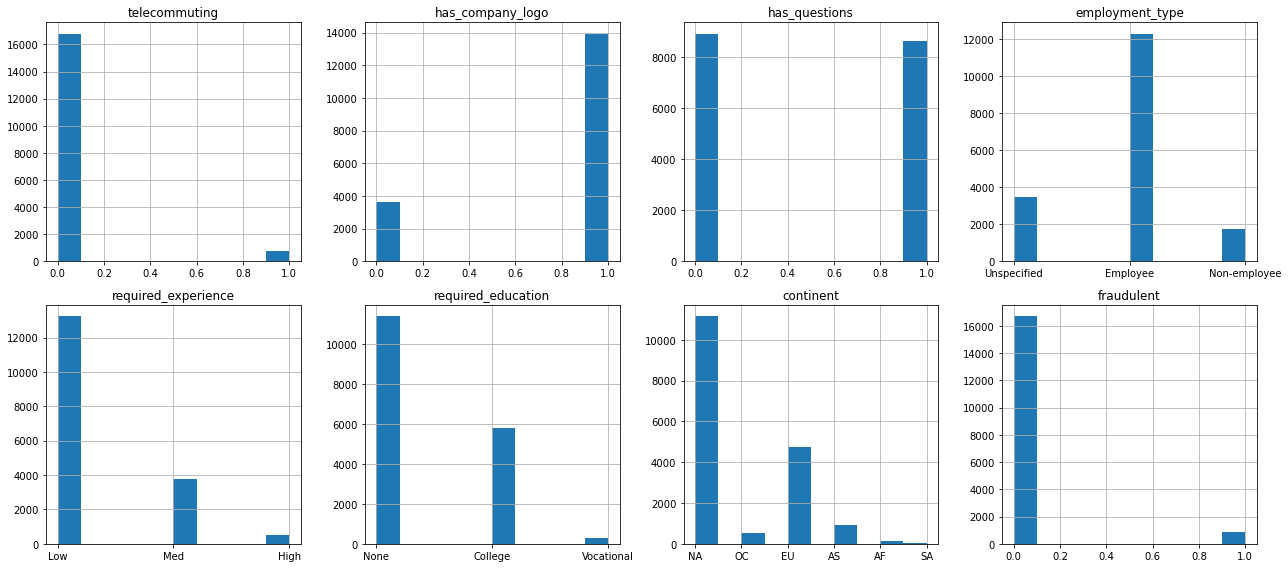

In [3]:
# view individual variable distributions
for k, col in enumerate(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'continent', 'fraudulent']):
    plt.subplot(2,4,k+1)
    jobs[col].hist(figsize=(18, 8))
    plt.title(col)
    plt.tight_layout();

In [4]:
# view summary statistics
jobs.select_dtypes('int64').describe().T

,count,mean,std,min,25%,50%,75%,max
telecommuting,17534.0,0.042546,0.201837,0.0,0.0,0.0,0.0,1.0
has_company_logo,17534.0,0.794399,0.404151,0.0,1.0,1.0,1.0,1.0
has_questions,17534.0,0.491616,0.499944,0.0,0.0,0.0,1.0,1.0
fraudulent,17534.0,0.048306,0.214418,0.0,0.0,0.0,0.0,1.0


Next, I will split my data into train, validate, and test datasets.

In [5]:
# split data
train, validate, test = w.split_data(jobs, 'fraudulent')
train.shape, validate.shape, test.shape

((9818, 23), (4209, 23), (3507, 23))

### Question 1: Are job listings without a higher education requirement more likely to be fake?

- $H_{0}$: There is not a relationship between job postings without a higher education requirement and authenticity of the job posting.
- $H_{a}$: There is a significant relationship between job postings without a higher education requirement and authenticity of the job posting.

There is sufficient evidence to move forward with the alternative hypothesis that there is a significant relationship between job postings without a higher education requirement and authenticity of the job posting.


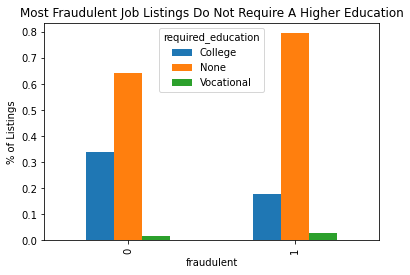

In [6]:
pd.crosstab(train.fraudulent, train.required_education, normalize='index').plot.bar().set(title='Most Fraudulent Job Listings Do Not Require A Higher Education', ylabel='% of Listings');
alpha = 0.05

null_hypothesis = 'there is not a relationship between job postings without a higher education requirement and authenticity of the job posting.'
alt_hypothesis = 'there is a significant relationship between job postings without a higher education requirement and authenticity of the job posting.'
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.fraudulent, train.required_education_None))
chi2, p

if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

### Answer 1: Job postings without a higher education requirement are fraudulent more often than job postings that do specify a higher education requirement.

### Question 2: Is there a region that is more likely to have fake job listings?
- $H_{0}$: There is not a relationship between fraudulent job listings and job listings in North America.
- $H_{a}$: There is a significant relationship between fraudulent job listings and job listings in North America.

There is sufficient evidence to move forward with the alternative hypothesis that there is a significant relationship between fraudulent job listings and job listings in North America.


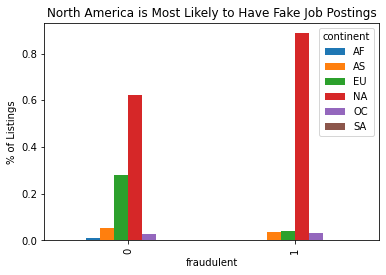

In [7]:
pd.crosstab(train.fraudulent, train.continent, normalize='index').plot.bar().set(title='North America is Most Likely to Have Fake Job Postings', ylabel='% of Listings');
alpha = 0.05

null_hypothesis = 'there is not a relationship between fraudulent job listings and job listings in North America.'
alt_hypothesis = 'there is a significant relationship between fraudulent job listings and job listings in North America.'
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.fraudulent, train.continent_NA))
chi2, p

if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

### Answer 2: Job listings with North America as their location are more likely to be fraudulent than listings specifying other regions as their location.

### Question 3: Is there a difference in frequency of fake job listings across employment types? 

Question rephrased for stat test: Is there a relationship between fraudulent job listings and job listings with unspecified employment types?

- $H_{0}$: There is not a relationship between fraudulent job listings and unspecified employment types in job listings.
- $H_{a}$: There is a significant relationship between fraudulent job listings and unspecified employment types in job listings.

There is sufficient evidence to move forward with the alternative hypothesis that there is a significant relationship between fraudulent job listings and unspecified employment types.


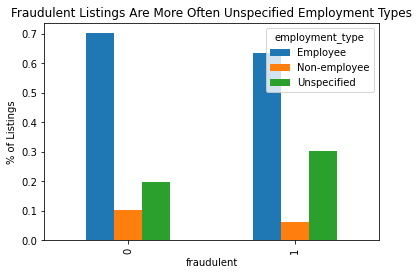

In [8]:
pd.crosstab(train.fraudulent, train.employment_type, normalize='index').plot.bar().set(title='Fraudulent Listings Are More Often Unspecified Employment Types', ylabel='% of Listings');
alpha = 0.05

null_hypothesis = 'there is not a relationship between fraudulent job listings and unspecified employment types.'
alt_hypothesis = 'there is a significant relationship between fraudulent job listings and unspecified employment types.'
chi2, p, degf, expected = stats.chi2_contingency(pd.crosstab(train.fraudulent, train.employment_type_Unspecified))
chi2, p

if p > alpha:
    print(f'There is not sufficient evidence to reject our null hypothesis that {null_hypothesis}')
else:
    print(f'There is sufficient evidence to move forward with the alternative hypothesis that {alt_hypothesis}')

### Answer 3: There is a relationship between job listings with unspecified employment types and whether or not the listing is authentic.

### Question 4: Are there any words or phrases that occur commonly in fake job listings?

This question won't be a part of the models I created in the next step, but it is definitely something I wanted to look into. If there are buzzwords that occur more frequently in fake job postings, that's absolutely something I want to document.

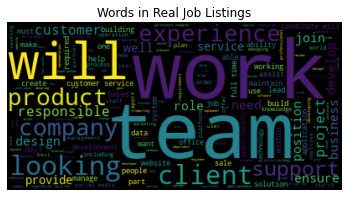

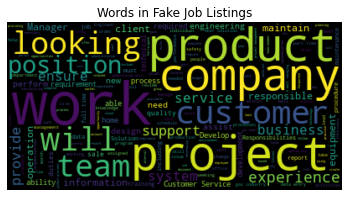

In [9]:
# generate word clouds
desc = w.get_descriptions()

real = desc[desc.fraudulent == 0]
plt.imshow(WordCloud().generate(real.description.str.cat()), interpolation='bilinear')
plt.title('Words in Real Job Listings')
plt.axis("off")
plt.show();

fake = desc[desc.fraudulent == 1]
plt.imshow(WordCloud().generate(fake.description.str.cat()), interpolation='bilinear')
plt.title('Words in Fake Job Listings')
plt.axis("off")
plt.show();

### Answer 4: There do not appear to be any significant differences between words most often used in fake job listings and words most often used in real job listings.

### Exploration Takeaways:
- Most of these job postings in this dataset are not fraudulent.
- Most job postings do have a company logo.
- About half of these listings have questions.
- Most listings are located in North America.
- Most listings are for employee positions.
- Most listings did not specify that a higher education degree is required.
- Most listings require minimal experience.

---
## Modeling

Although applying to a fraudulent job posting could have detrimental effects such as identity theft, I also want to minimize the amount of real jobs being classified as fraudulent so I don't miss out on a great job opportunity. Therefore, I chose accuracy as my evaluation metric.

Evaluation Metric: Accuracy

Baseline Prediction: 0 (Authentic)

In [10]:
# create x and y versions of train, validate, and test samples
x_train = train.drop(columns=['fraudulent', 'continent', 'employment_type', 'required_education', 'required_experience'])
y_train = train.fraudulent

x_validate = validate.drop(columns=['fraudulent', 'continent', 'employment_type', 'required_education', 'required_experience'])
y_validate = validate.fraudulent

x_test = test.drop(columns=['fraudulent', 'continent', 'employment_type', 'required_education', 'required_experience'])
y_test = test.fraudulent

### Baseline

In [11]:
# compute baseline accuracy
print(f'Baseline Accuracy on Train: {(y_train == 0).mean():.2%}')
print(f'Baseline Accuracy on Validate: {(y_validate == 0).mean():.2%}')

Baseline Accuracy on Train: 95.16%
Baseline Accuracy on Validate: 95.18%


### Model 1: Decision Tree
For this model, I will be using all of the features in my dataframe, a max depth of 3, and I will set the random state to 123 for reproducibility.

In [12]:
# create decision tree object
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
# fit object to train
clf = clf.fit(x_train, y_train)
# make predictions
y_pred1 = clf.predict(x_train)
y_pred_v1 = clf.predict(x_validate)
# compute and print accuracy
print(f'Model 1 Train Accuracy: {accuracy_score(y_train, y_pred1):.2%}')
print(f'Model 1 Validate Accuracy: {accuracy_score(y_validate, y_pred_v1):.2%}')

Model 1 Train Accuracy: 95.16%
Model 1 Validate Accuracy: 95.18%


### Model 2: Random Forest
For this model, I will be using all of the features in my dataframe. I will set minimum samples per leaf to 1 and max depth to 10. I will also set a random state (123) so my work can be reproduced.

In [13]:
# create random forest object
rf = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
# fit object to train sample
rf.fit(x_train, y_train)
# make predictions
y_pred2 = rf.predict(x_train)
y_pred_v2 = rf.predict(x_validate)
# compute and print accuracy
print(f'Model 2 Train Accuracy: {accuracy_score(y_train, y_pred2):.2%}')
print(f'Model 2 Validate Accuracy: {accuracy_score(y_validate, y_pred_v2):.2%}')

Model 2 Train Accuracy: 95.44%
Model 2 Validate Accuracy: 95.58%


### Model 3: Random Forest
For this model, I will only be using the features that started off as int dtypes. I will leave the hyperparameters the same as in Model 2.

In [14]:
# create random forest object
rf2 = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
# fit object to train sample
rf2.fit(x_train[['telecommuting', 'has_company_logo', 'has_questions']], y_train)
# make predictions
y_pred3 = rf2.predict(x_train[['telecommuting', 'has_company_logo', 'has_questions']])
y_pred_v3 = rf2.predict(x_validate[['telecommuting', 'has_company_logo', 'has_questions']])
# compute and print accuracy
print(f'Model 3 Train Accuracy: {accuracy_score(y_train, y_pred3):.2%}')
print(f'Model 3 Validate Accuracy: {accuracy_score(y_validate, y_pred_v3):.2%}')

Model 3 Train Accuracy: 95.16%
Model 3 Validate Accuracy: 95.18%


#### My best model is Model 2. It has an accuracy of 95.44% on train and 95.58% on validate. Both of these beat the baseline! Next, I will run this model on the test dataset.

In [15]:
# create random forest object
rf = RandomForestClassifier(min_samples_leaf=1, max_depth=10, random_state=123)
# fit object to train sample
rf.fit(x_train, y_train)
# make predictions
y_pred_t2 = rf.predict(x_test)
# compute and print accuracy
print(f'Model 2 Test Accuracy: {accuracy_score(y_test, y_pred_t2):.2%}')

Model 2 Test Accuracy: 95.32%


---
## Conclusion

### Summary
Through exploring this data, I discovered fraudulent job postings are very similar to authentic job postings. By using the features in this dataset, I was able to create a model for classifying job postings as real or fake with an accuracy of 95.32%. There is still room for improvement and it is in all job seekers' best interest to be able to accurately discern whether a job posting is real or not.

### Recommendation
Always stay vigilant when giving personal information to potential employers. Fake job listings are becoming both more common and more sophisticated as time progresses.

### Next Steps
Given more time and resources, I would like to find more job listings that do specify a salary range. The majority of entries in this dataset did not have a salary range but I think it would be interesting to see what, if any, relationship there is between stated salary ranges and authenticity of job postings.